### **1. MENCARI KEYWORD YANG SERING MUNCUL PADA WEB DEFACEMENT DENGAN STATISTIK**

In [ ]:
import os
import re
from collections import Counter
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.util import ngrams
import nltk
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import IPython.display as display


nltk.download('punkt')
nltk.download('punkt_tab') # This line is added to download punkt_tab

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ganti dengan path folder kamu
defaced_path = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Defaced"
normal_path_ID = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal ID"
normal_path_EN = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal"

def read_all_txt_files(folder_path):
    all_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', errors='ignore') as f:
                try:
                    content = f.read()
                    all_texts.append(content)
                except:
                    pass
    return all_texts

# Ekstrak teks dari html
def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")

    body_text = soup.body.get_text(separator=" ", strip=True) if soup.body else ""
    title_text = soup.title.string.strip() if soup.title and soup.title.string else ""

    meta_keywords = ''
    meta_description = ''
    for meta in soup.find_all('meta'):
        if meta.get('name') == 'keywords' and meta.get('content'):
            meta_keywords = meta['content']
        elif meta.get('name') == 'description' and meta.get('content'):
            meta_description = meta['content']

    scripts = soup.find_all("script")
    js_alerts = []
    for script in scripts:
        if script.string:
            alerts = re.findall(r'alert\((.*?)\)', script.string)
            js_alerts.extend(alerts)
    js_alert_text = " ".join(js_alerts)

    combined_text = f"{title_text} {meta_keywords} {meta_description} {body_text} {js_alert_text}"
    return combined_text

# Filter token agar tidak berisi hanya simbol
def is_valid_token(token):
    if all(char in string.punctuation for char in token):
        return False
    if len(token) < 2:
        return False
    return True

def tokenize_and_ngrams(text, n=2):
    tokens = word_tokenize(text.lower())
    #tokens = [t for t in tokens if is_valid_token(t)] #Fungsi Untuk Mengambil Tokens Tanpa Simbol / Tanda Baca
    unigrams = tokens
    bigrams = [' '.join(gram) for gram in ngrams(tokens, 2)]
    return unigrams + bigrams

def get_smallest_files(directory, limit):
    """Mengambil file .txt terkecil dalam folder hingga batas tertentu."""
    try:
        files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
        files_sorted = sorted(files, key=os.path.getsize)[:limit]
        return files_sorted
    except Exception as e:
        print(f"Error accessing {directory}: {e}")
        return []

def read_all_txt_files_limited(path, limit):
    """Membaca isi dari file .txt terkecil berdasarkan limit."""
    txt_files = get_smallest_files(path, limit)
    htmls = []
    for file_path in txt_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                htmls.append(f.read())
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return htmls

# Proses folder dengan batasan jumlah file
def process_folder(path, limit):
    htmls = read_all_txt_files_limited(path, limit)
    all_tokens = []
    for html in htmls:
        clean_text = extract_text_from_html(html)
        tokens = tokenize_and_ngrams(clean_text)
        all_tokens.extend(tokens)
    return Counter(all_tokens)

# Hitung frekuensi token dari file terbatas
defaced_counter = process_folder(defaced_path, limit=6200)
normal_counter_ID = process_folder(normal_path_ID, limit=4000)
normal_counter_EN = process_folder(normal_path_EN, limit=2200)

# Gabungkan hasilnya
normal_counter = normal_counter_ID + normal_counter_EN

# Gabungkan semua token
all_tokens = set(defaced_counter.keys()).union(set(normal_counter.keys()))

# Buat perbandingan frekuensi dalam DataFrame
comparison_data = []
for token in all_tokens:
    defaced_freq = defaced_counter.get(token, 0)
    normal_freq = normal_counter.get(token, 0)
    diff = defaced_freq - normal_freq
    comparison_data.append((token, defaced_freq, normal_freq, diff))

df = pd.DataFrame(comparison_data, columns=['token', 'defaced_freq', 'normal_freq', 'difference'])

# Urutkan berdasarkan perbedaan frekuensi (token khas deface)
df_top = df.sort_values(by='difference', ascending=False).head(100)

display.display(df_top)

# Opsional: Simpan ke CSV
df_top.to_csv('/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Hasil/3.1. Statistik - Perbandingan Kemunculan Keyword Defaced VS Normal.csv', index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive


,token,defaced_freq,normal_freq,difference
813371,", ,",101636,70,101566
1112303,|,62020,6194,55826
984226,| |,43949,22,43927
430696,",",131307,115179,16128
357579,-,25062,11029,14033
...,...,...,...,...
35331,by mhx404,512,0,512
291247,mhx404,512,0,512
1209411,mhx404 ethersec,510,0,510
1289146,mr,529,20,509


### **1.1 MENCARI KEYWORD DAN SIMBOL YANG SERING MUNCUL PADA WEB DEFACEMENT DENGAN TF IDF DAN CHI SQUARE**

In [ ]:
# ======================== [0] Install dan Import ========================
!pip install beautifulsoup4 --quiet

import os
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from google.colab import drive

# ======================== [1] Mount Google Drive ========================
drive.mount('/content/drive')

# ======================== [2] Path Dataset ========================
defaced_path = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Defaced"
normal_path_ID = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal ID"
normal_path_EN = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal"

# ======================== [3] Baca File HTML ========================
def get_smallest_files(directory, limit):
    try:
        files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
        return sorted(files, key=os.path.getsize)[:limit]
    except Exception as e:
        print(f"Error accessing {directory}: {e}")
        return []

def read_all_txt_files_limited(path, limit):
    htmls = []
    for file_path in get_smallest_files(path, limit):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                htmls.append(f.read())
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return htmls

# ======================== [4] Ekstraksi Teks HTML ========================
def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    title = soup.title.string.strip() if soup.title and soup.title.string else ""
    body = soup.body.get_text(separator=" ", strip=True) if soup.body else ""
    meta_keywords = ''
    meta_description = ''
    for meta in soup.find_all('meta'):
        if meta.get('name') == 'keywords' and meta.get('content'):
            meta_keywords = meta['content']
        elif meta.get('name') == 'description' and meta.get('content'):
            meta_description = meta['content']
    scripts = soup.find_all("script")
    js_alerts = []
    for script in scripts:
        if script.string:
            alerts = re.findall(r'alert\((.*?)\)', script.string)
            js_alerts.extend(alerts)
    js_alert_text = " ".join(js_alerts)
    return f"{title} {meta_keywords} {meta_description} {body} {js_alert_text}"

# ======================== [5] Simbol Preservation Preprocessing ========================
def preserve_symbols(text):
    patterns = [
        r'\| \|', r'\|\|', r'--', r'!!!', r'\*\*', r', ,', r'###',
        r'==+', r'▓▒░', r'✯+', r'██+', r'\.\.\.', r'::', r'> <'
    ]
    for pat in patterns:
        text = re.sub(pat, lambda m: f' {m.group(0)} ', text)
    return text

# Gabungan
def clean_and_preserve(text):
    text = extract_text_from_html(text)
    text = preserve_symbols(text)
    return text

# ======================== [6] Load Data ========================
def load_clean_texts(path, limit):
    raw_htmls = read_all_txt_files_limited(path, limit)
    texts = []
    for html in tqdm(raw_htmls, desc=f"Processing {path}"):
        clean = clean_and_preserve(html)
        if clean.strip():
            texts.append(clean)
    return texts

def custom_tokenizer(text):
    # Tangkap token secara berurutan berdasarkan prioritas
    pattern = re.compile(r"""
        \|\s?\|         |  # | | atau ||
        --              |  # double dash
        !!!             |  # triple exclamation
        \*\*            |  # double asterisk
        ,\s?,           |  # comma comma
        ###             |  # triple hash
        ==+             |  # equal signs
        ▓▒░             |  # ascii block
        ✯+              |  # stars
        ██+             |  # dark block
        \.\.\.          |  # ellipsis
        ::              |  # double colon
        >\s?<           |  # > <
        [A-Za-z0-9_]+   |  # normal words
        [^\s\w]            # single symbols
    """, re.VERBOSE)
    return pattern.findall(text)

def separate_symbols(text):
    # Pisahkan setiap simbol non-word dan non-space agar jadi token sendiri
    return re.sub(r'([^\w\s])', r' \1 ', text)

vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    lowercase=False,
    stop_words=None,
    max_features=None,
    ngram_range=(1, 3)
)

defaced_texts = load_clean_texts(defaced_path, 6200)
normal_texts = load_clean_texts(normal_path_ID, 4000) + load_clean_texts(normal_path_EN, 2200)

# ======================== [7] TF-IDF + Chi-Square ========================
texts = defaced_texts + normal_texts
labels = [1] * len(defaced_texts) + [0] * len(normal_texts)

X = vectorizer.fit_transform(texts)
y = np.array(labels)

chi_scores, p_values = chi2(X, y)
feature_names = np.array(vectorizer.get_feature_names_out())

defaced_vector = X[np.array(labels) == 1]
normal_vector = X[np.array(labels) == 0]

defaced_freq = np.array((defaced_vector > 0).sum(axis=0)).flatten()
normal_freq = np.array((normal_vector > 0).sum(axis=0)).flatten()

# Deteksi simbol
symbol_pattern = re.compile(r"^[^\w\s]+$")  # Simbol murni tanpa huruf/angka
token_type = ["symbol" if symbol_pattern.match(token) else "word" for token in feature_names]

# ======================== [8] Gabungkan dan Simpan ========================
df = pd.DataFrame({
    "token": feature_names,
    "type": token_type,
    "chi2_score": chi_scores,
    "p_value": p_values,
    "defaced_freq": defaced_freq,
    "normal_freq": normal_freq
})

df = df.sort_values(by="chi2_score", ascending=False)

output_csv = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Hasil/3.1. Chi Square - Perbandingan Kemunculan Keyword & Symbol Defaced VS Normal.csv"
df.to_csv(output_csv, index=False)

df.head(500)

Mounted at /content/drive


Processing /content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Defaced: 100%|██████████| 6200/6200 [00:37<00:00, 164.18it/s]
Processing /content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal ID: 100%|██████████| 4000/4000 [02:42<00:00, 24.65it/s]
Processing /content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal: 100%|██████████| 2200/2200 [01:28<00:00, 24.84it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,token,type,chi2_score,p_value,defaced_freq,normal_freq
1445605,Hacked,word,175.136688,5.589302e-40,4611,6
111928,",",symbol,169.187509,1.113333e-38,2352,5581
1445766,Hacked By,word,136.121575,1.876801e-31,3470,0
2904418,and,word,132.696345,1.053542e-30,632,2940
1009650,By,word,127.579708,1.387164e-29,4164,671
...,...,...,...,...,...,...
742210,@ gmail,word,6.601367,1.019005e-02,520,521
2803937,] Hacked By,word,6.600316,1.019607e-02,129,0
2696510,Video,word,6.599544,1.020049e-02,106,715
742211,@ gmail .,word,6.597637,1.021142e-02,519,520


In [ ]:
!pip install fuzzywuzzy python-Levenshtein --quiet

import os
import re
import pandas as pd
from tqdm import tqdm
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
from google.colab import drive

# ============ [1] Mount Google Drive ============
drive.mount('/content/drive')

# ============ [2] Deface Keyword & Symbol List ============
def deface_keywords():
    return [
        "hacked by",
        "xploit",
        "touched",
        "hacker",
        "cyber team"
    ]

def deface_symbols():
    return ["~", "||", "--", "!!!", "::", "| |", "| --", ", ,"]

leet_variants = {
    'a': ['a', '@', '4'], 'e': ['e', '3'], 'i': ['i', '1', '!'],
    'o': ['o', '0'], 's': ['s', '$', '5'], 't': ['t', '7'], 'b': ['b', '8'],
    'g': ['g', '9'], 'z': ['z', '2'], 'c': ['c', '('], 'h': ['h', '#'],
    'l': ['l', '|', '1'], 'd': ['d'], 'u': ['u'], 'r': ['r'], 'n': ['n'],
    'w': ['w'], 'y': ['y'], 'm': ['m'], 'k': ['k'], 'f': ['f'], 'x': ['x']
}

# ============ [3] Regex Generator ============
def word_to_regex(word):
    pattern = ''
    for ch in word:
        if ch.lower() in leet_variants:
            group = ''.join(set(leet_variants[ch.lower()]))
            pattern += f"[{group}]"
        else:
            pattern += re.escape(ch)
    return pattern

def build_keyword_regexes():
    patterns = []
    for kw in deface_keywords():
        words = re.sub(r"\s+", " ", kw.strip()).split()
        if len(words) == 1:
            patterns.append((kw, word_to_regex(words[0])))
        else:
            regex_parts = [word_to_regex(w) for w in words]
            patterns.append((kw, r"\s+".join(regex_parts)))
    return patterns

regex_patterns = build_keyword_regexes()

# ============ [4] Ekstraksi HTML ============
def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    title = soup.title.string.strip() if soup.title and soup.title.string else ""
    body = soup.body.get_text(separator=" ", strip=True) if soup.body else ""
    metas = ' '.join(meta.get('content', '') for meta in soup.find_all('meta') if meta.get('content'))
    scripts = ' '.join(re.findall(r'alert\((.*?)\)', str(soup.find_all('script'))))
    return f"{title} {metas} {body} {scripts}"

# ============ [5] Load Dataset ============
def read_all_txt_files(folder_path, limit=None):
    files = [f for f in os.listdir(folder_path) if f.endswith(".txt")]
    if limit: files = sorted(files, key=lambda f: os.path.getsize(os.path.join(folder_path, f)))[:limit]
    texts = []
    for file in tqdm(files, desc=f"Reading from {folder_path}"):
        try:
            with open(os.path.join(folder_path, file), 'r', encoding='utf-8', errors='ignore') as f:
                html = f.read()
                cleaned = extract_text_from_html(html)
                texts.append((file, cleaned))
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return texts

# ============ [6] Deteksi Keyword & Simbol ============
def detect_keywords(text, threshold=85):
    results = []
    for label, pattern in regex_patterns:
        if re.search(pattern, text, re.IGNORECASE):
            results.append((label, "REGEX MATCH", "keyword"))
        elif fuzz.partial_ratio(label.lower(), text.lower()) >= threshold:
            results.append((label, "FUZZY MATCH", "keyword"))
    return results

def detect_symbols_advanced(text, min_count=3):
    results = []
    for symbol in deface_symbols():
        count = text.count(symbol)
        if count >= min_count:
            results.append((symbol, f"SYMBOL COUNT ({count})", "symbol"))
    return results

# ============ [7] Jalankan Deteksi ============
#folder_path = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Defaced"
folder_path = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal ID"
texts = read_all_txt_files(folder_path, limit=4000)

records = []
for filename, text in tqdm(texts, desc="Processing documents"):
    keyword_matches = detect_keywords(text)
    symbol_matches = detect_symbols_advanced(text)

    # Check if any matches were found
    if keyword_matches or symbol_matches:
        for token, match_type, match_class in keyword_matches + symbol_matches:
            records.append({
                "filename": filename,
                "matched_token": token,
                "match_type": match_type,
                "match_class": match_class
            })
    else:
        # If no matches, append a record with filename and None for other values
        records.append({
            "filename": filename,
            "matched_token": None,
            "match_type": None,
            "match_class": None
        })

# ============ [8] Simpan ke CSV ============
result_df = pd.DataFrame(records).drop_duplicates()
result_df = result_df.sort_values(by=["filename", "matched_token"])
#output_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Hasil/3.2 Defaced - Cek Kumungkinan Munculnya Keyword dan Symbol.csv"
output_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Hasil/3.2 Normal ID - Cek Kumungkinan Munculnya Keyword dan Symbol.csv"
result_df.to_csv(output_path, index=False)

print(f"✅ Hasil disimpan ke: {output_path}")
result_df.head(400)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading from /content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal ID: 100%|██████████| 4000/4000 [03:39<00:00, 18.22it/s]
Processing documents: 100%|██████████| 4000/4000 [00:04<00:00, 901.30it/s]

✅ Hasil disimpan ke: /content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Hasil/3.2 Normal ID - Cek Kumungkinan Munculnya Keyword dan Symbol.csv


,filename,matched_token,match_type,match_class
84,0kedrive.my.id.txt,None,None,None
3627,a-khusnaa.my.id.txt,None,None,None
3414,a-tour.co.id.txt,None,None,None
2014,aaitasikmalaya.or.id.txt,None,None,None
1404,aaliyahisabella.my.id.txt,None,None,None
...,...,...,...,...
1581,belajargiat.id.txt,None,None,None
3697,belajarkreatif.org.txt,None,None,None
553,belanjaaman.site.txt,None,None,None
702,belanjaaman.store.txt,None,None,None


# **2. Membuat Total Element Yang Sering Digunakan Pada Web Teretas dan Normal**

In [ ]:
!pip install langdetect

import os
import re
import pandas as pd
import math
from bs4 import BeautifulSoup
from collections import Counter
from langdetect import detect, LangDetectException
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path dataset
normal_path_ID = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal ID"
normal_path_EN = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Normal"
defaced_path = "/content/drive/My Drive/Colab Notebooks/2. Dataset/Dataset Defaced"
output_csv = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/2. Ekstrak Feature Dataset.csv"
batch_size = 200  # Simpan setiap 200 file

def shannon_entropy(data):
    if not data:
        return 0
    entropy = 0
    length = len(data)
    frequency = {}
    for char in data:
        frequency[char] = frequency.get(char, 0) + 1
    for freq in frequency.values():
        p = freq / length
        entropy -= p * math.log2(p)
    return entropy

def max_dom_depth(soup):
    def depth(elm, current=0):
        if not hasattr(elm, 'contents') or not elm.contents:
            return current
        return max([depth(child, current + 1) for child in elm.contents if hasattr(child, 'name')])
    return depth(soup)

def extract_features(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    content_lower = html_content.lower()

    # 1. Nama gambar
    img_tags = soup.find_all('img')
    img_filenames = [os.path.basename(img.get('src', '')) for img in img_tags if img.get('src')]
    img_weird_names = sum(1 for name in img_filenames if re.search(r'(php|hacked|[0-9]{3,})', name) is not None)

    # 2. JavaScript
    scripts = soup.find_all('script')
    js_code = ' '.join(script.text for script in scripts)
    js_redirect = int(bool(re.search(r'window\.location|window\.open|location\.href', js_code) is not None))
    js_iframe = int(bool(soup.find('iframe')))
    js_meta_refresh = int(bool(soup.find('meta', attrs={'http-equiv': 'refresh'})))
    js_alert = int('alert(' in js_code)
    js_autoplay_audio = int(bool(soup.find('audio', attrs={'autoplay': True})))
    js_event_listener = int(bool(re.search(r'onload=|onclick=|addEventListener', html_content, re.IGNORECASE) is not None))
    js_obfuscated = int(
      'eval(' in js_code or
      'atob(' in js_code or
      (re.search(r'(\\x|\\u[0-9a-f]{2,4})', js_code) is not None)
    )
    all_js = []
    for scripts in soup.find_all('script'):
        if scripts.string:
          all_js.append(scripts.string)
    js_code = "\n".join(all_js)
    js_entropy = shannon_entropy(js_code)

    # 3. CSS
    styles = soup.find_all('style')
    css_code = ' '.join(style.text for style in styles)
    css_black_bg = int('background-color: black' in css_code or 'background:black' in css_code)
    css_display_none = int('display:none' in css_code)
    css_white_text = int('color: #fff' in css_code or 'color:white' in css_code)
    all_css = []
    for styles in soup.find_all('style'):
        if styles.string:
            all_css.append(styles.string)
    css_code = "\n".join(all_css)
    css_entropy = shannon_entropy(css_code)

    # 4. Text & Meta
    text_content = soup.get_text().lower()
    hacker_signatures = ["hacked by", "| |", "hacked", ", ,", "--", "| --"]
    found_keywords = sum(1 for k in hacker_signatures if k in text_content)
    meta_tags = soup.find_all('meta')

    # Meta title dengan error handling
    try:
        meta_title = soup.title.string.strip() if soup.title and soup.title.string else ''
    except Exception:
        meta_title = ''
    meta_tags = soup.find_all('meta')
    meta_title_length = len(meta_title)
    meta_keyword_flag = int(any('keyword' in (tag.get('name') or '').lower() for tag in meta_tags))
    meta_description_flag = int(any('description' in (tag.get('name') or '').lower() for tag in meta_tags))
    html_comments = len(re.findall(r'<!--.*?-->', html_content, flags=re.DOTALL))

    # 5. Struktur & link eksternal
    total_links = soup.find_all(['a', 'script', 'img', 'link'])
    external_links = sum(
        1 for tag in total_links if any(
            isinstance(tag.get(attr), str) and tag.get(attr).startswith('http') for attr in ['href', 'src']
        )
    )
    has_floating_element = int(bool(re.search(r'position:\s*fixed|absolute', css_code) is not None))

    #tag html
    tags = [tag.name for tag in soup.find_all()]
    tag_count = Counter(tags)
    text = soup.get_text().lower()

     # === New features added ===
    offensive_words = ['fuck', 'owned', 'noob', 'lame', 'bitch', 'death', 'kill', 'virus']
    offensive_count = sum(text.count(w) for w in offensive_words)

    ratio_capital_letters = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0

    try:
        lang = detect(text[:1000])
    except LangDetectException:
        lang = "unknown"

    inline_js = int(bool(re.search(r'on(click|load|mouseover)=', html_content, re.IGNORECASE)))
    inline_style_fixed = int(bool(re.search(r'style\s*=\s*".*?(position\s*:\s*(fixed|absolute)).*?"', html_content, re.IGNORECASE)))

    unusual_tags = ['marquee', 'blink', 'applet', 'center', 'font', 'b', 'u', 'strike']
    unusual_tag_count = sum(text.count(f"<{tag}") for tag in unusual_tags)

    ip_links = sum(1 for tag in total_links if any(
        re.match(r'^http://\d{1,3}(\.\d{1,3}){3}', str(tag.get(attr, '')))
        for attr in ['href', 'src']
    ))

    suspicious_links = sum(1 for tag in total_links if any(
        re.search(r'(pastebin|anonfiles|telegram|discord|mega)', str(tag.get(attr, '')).lower())
        for attr in ['href', 'src']
    ))

    filetype_links = sum(1 for tag in total_links if any(
        str(tag.get(attr, '')).lower().endswith(ext) for ext in ['.php', '.exe', '.zip']
        for attr in ['href', 'src']
    ))

    dom_depth = max_dom_depth(soup)

    total_tag_count = sum(tag_count.values())
    text_word_count = len(text.split())
    tag_to_text_ratio = total_tag_count / (text_word_count + 1)
    script_to_text_ratio = len(js_code.split()) / (text_word_count + 1)
    img_to_text_ratio = len(img_tags) / (text_word_count + 1)

    visual_density = sum(tag_count.values()) / (len(text) + 1)
    script_visual_ratio = script_to_text_ratio / (tag_to_text_ratio + 1)
    alert_keywords_combo = js_alert + found_keywords
    image_script_ratio = len(img_tags) / (script_to_text_ratio + 1)


    return {
        'img_total': len(img_tags),
        'img_weird_names': img_weird_names,
        'js_total': len(scripts),
        'js_redirect': js_redirect,
        'js_iframe': js_iframe,
        'js_meta_refresh': js_meta_refresh,
        'js_alert': js_alert,
        'js_autoplay_audio': js_autoplay_audio,
        'js_event_listener': js_event_listener,
        'js_obfuscated': js_obfuscated,
        'js_entropy': js_entropy,
        'css_black_bg': css_black_bg,
        'css_display_none': css_display_none,
        'css_white_text': css_white_text,
        'css_entropy': css_entropy,
        'found_keywords': found_keywords,
        'meta_title_length': meta_title_length,
        'meta_keyword_flag': meta_keyword_flag,
        'meta_description_flag': meta_description_flag,
        'html_comment_count': html_comments,
        'external_links': external_links,
        'has_floating_element': has_floating_element,
        'total_tags': sum(tag_count.values()),
        'unique_tags': len(tag_count),
        'text_length': len(text),
        'count_capital_words': sum(1 for word in text.split() if word.isupper()),

        # Extra features
        'offensive_word_count': offensive_count,
        'capital_ratio': ratio_capital_letters,
        'detected_language': lang,
        'inline_js_event': inline_js,
        'inline_style_fixed': inline_style_fixed,
        'unusual_tag_count': unusual_tag_count,
        'ip_links': ip_links,
        'suspicious_links': suspicious_links,
        'filetype_links': filetype_links,
        'dom_max_depth': dom_depth,
        'tag_to_text_ratio': tag_to_text_ratio,
        'script_to_text_ratio': script_to_text_ratio,
        'img_to_text_ratio': img_to_text_ratio,

        # Extra Features Combo
        'visual_density': visual_density,
        'script_visual_ratio': script_visual_ratio,
        'alert_keywords_combo': alert_keywords_combo,
        'image_script_ratio': image_script_ratio,

    }

def get_smallest_files(directory, limit=6400):
    try:
        files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        files_sorted = sorted(files, key=os.path.getsize)[:limit]
        return files_sorted
    except Exception as e:
        print(f"Error accessing {directory}: {e}")
        return []

def process_files(files, label):
    existing_files = set()
    if os.path.exists(output_csv) and os.path.getsize(output_csv) > 0:
        try:
            df_existing = pd.read_csv(output_csv)
            if "filename" in df_existing.columns:
                existing_files = set(df_existing["filename"])
        except pd.errors.EmptyDataError:
            print("The output CSV file is empty. Starting fresh.")
        except Exception as e:
            print(f"Error loading existing CSV: {e}")

    data = []
    for i, file_path in enumerate(files):
        filename = os.path.basename(file_path)
        if filename in existing_files:
            continue

        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                raw_text = file.read()

            # Validasi file benar-benar HTML
            if not raw_text.strip().lower().startswith('<!doctype') and '<html' not in raw_text.lower():
                print(f"Skipping non-HTML file: {filename}")
                continue

            features = extract_features(raw_text)
            features['Label'] = label
            features['Filename'] = filename
            features['length'] = len(raw_text)
            data.append(features)

        except Exception as e:
            print(f"Error reading {file_path}: {e}")

        # Simpan per batch
        if (i + 1) % batch_size == 0 or (i + 1) == len(files):
            if data:  # Check if data list is not empty before creating DataFrame
                df = pd.DataFrame(data)
                df = df[['Filename', 'Label'] + [col for col in df.columns if col not in ['filename', 'label']]]
                if os.path.exists(output_csv):
                    df.to_csv(output_csv, mode='a', header=False, index=False)
                else:
                    df.to_csv(output_csv, index=False)
                print(f"Saved {i + 1} files so far...")

            # Clear data list even if DataFrame was not created
            data.clear()

# Eksekusi proses
print("Processing Normal Files ID dan EN...")
normal_data = process_files(get_smallest_files(normal_path_ID, 4000), label=0)
normal_data2 = process_files(get_smallest_files(normal_path_EN, 2200), label=0)

print("Processing Defaced Files...")
defaced_data = process_files(get_smallest_files(defaced_path, 6200), label=1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=ceae24a1f8b1a17aa1f9ebed13e3f4b781545ffe5470511cebd8c1f86cc8a5ea
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing Normal Files ID dan EN...
Saved 200 files so far...
Saved 400 files so far...
Saved 600 files so far...
Saved 800 files so far...
Saved 1000 files so far...
Saved 1200 files so far...
Saved 1400 files so far...
Saved 1600 files so far...
Saved 1800 files so far...
Saved 2000 files so far...
Saved 2200 files so far...
Saved 2400 files so far...
Saved 2600 files so far...
Saved 2800 files so far...
Saved 3000 files so far...
Saved 3200 file

**2.1 Menampilkan Perbandingan Elemen Dengan Grafik dan Gambar dan Akurasi Menggunakan Ablation Test dan Random Forest**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== [Laporan Klasifikasi] ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1550
           1       0.99      0.98      0.98      1550

    accuracy                           0.98      3100
   macro avg       0.98      0.98      0.98      3100
weighted avg       0.98      0.98      0.98      3100


=== [Akurasi Rule-Based: found_keywords >= 1] ===
Akurasi: 0.9206


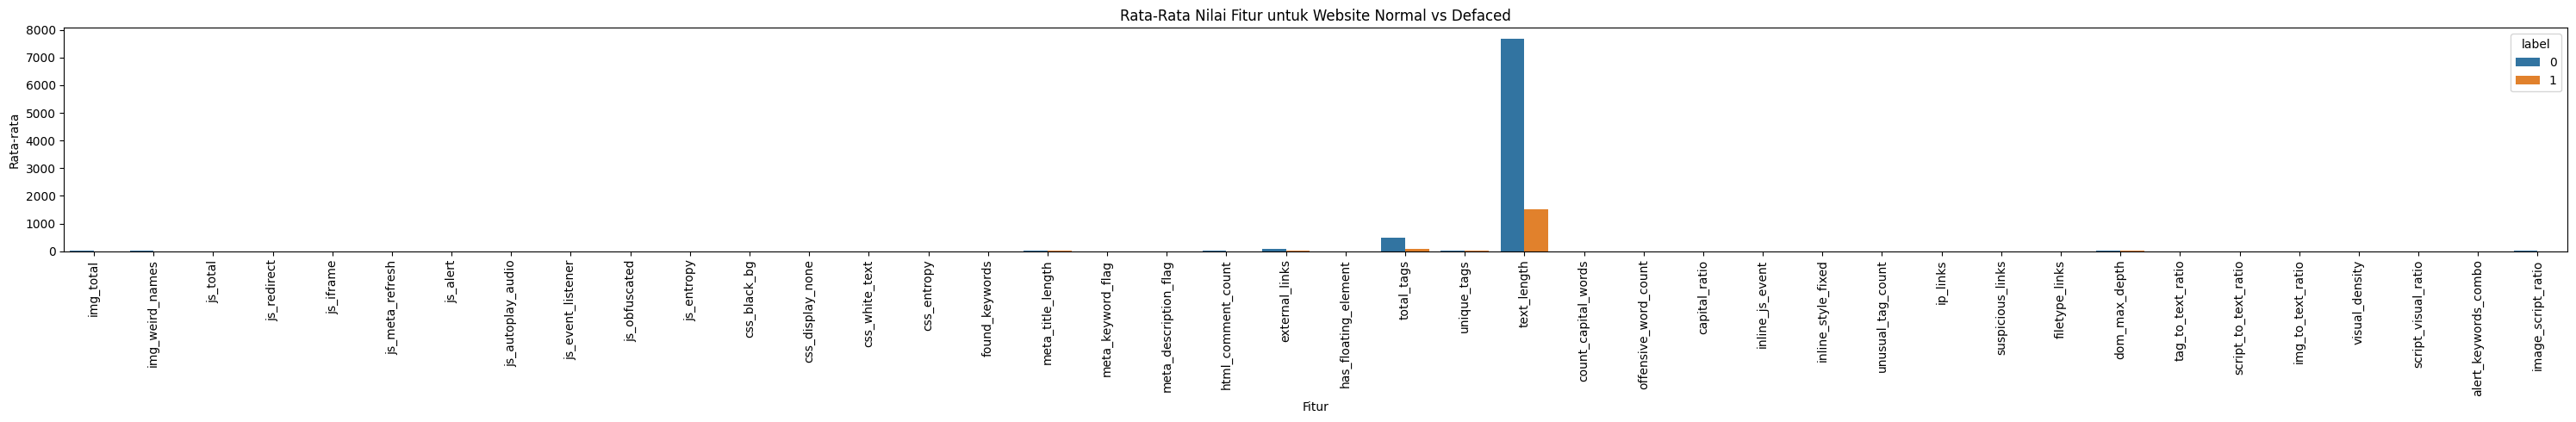

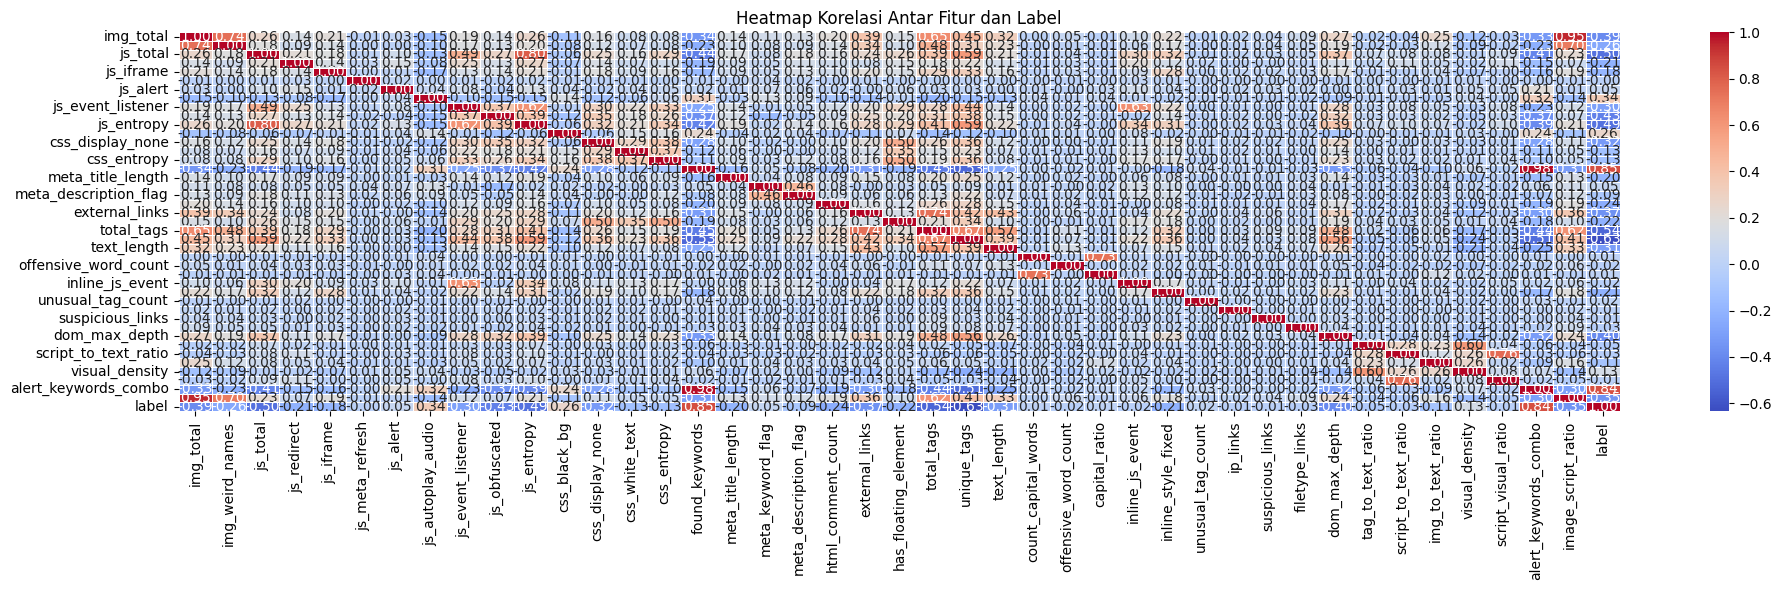


=== [Cross-Validated Feature Ablation Test] ===
          Removed Feature  Mean Accuracy   Std Dev
7       js_autoplay_audio       0.981047  0.002165
24            text_length       0.981612  0.002095
29     inline_style_fixed       0.981773  0.002271
21   has_floating_element       0.982095  0.001984
15         found_keywords       0.982096  0.002990
17      meta_keyword_flag       0.982257  0.001785
31               ip_links       0.982257  0.001991
3             js_redirect       0.982337  0.002078
16      meta_title_length       0.982337  0.001931
39    script_visual_ratio       0.982337  0.001122
11           css_black_bg       0.982337  0.001736
27          capital_ratio       0.982499  0.002570
4               js_iframe       0.982579  0.001452
34          dom_max_depth       0.982580  0.002437
6                js_alert       0.982660  0.001839
33         filetype_links       0.982660  0.002178
9           js_obfuscated       0.982741  0.001234
30      unusual_tag_count       0

<ipython-input-3-c7985fef9c14>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ablation_df, x="Removed Feature", y="Mean Accuracy", palette="viridis")


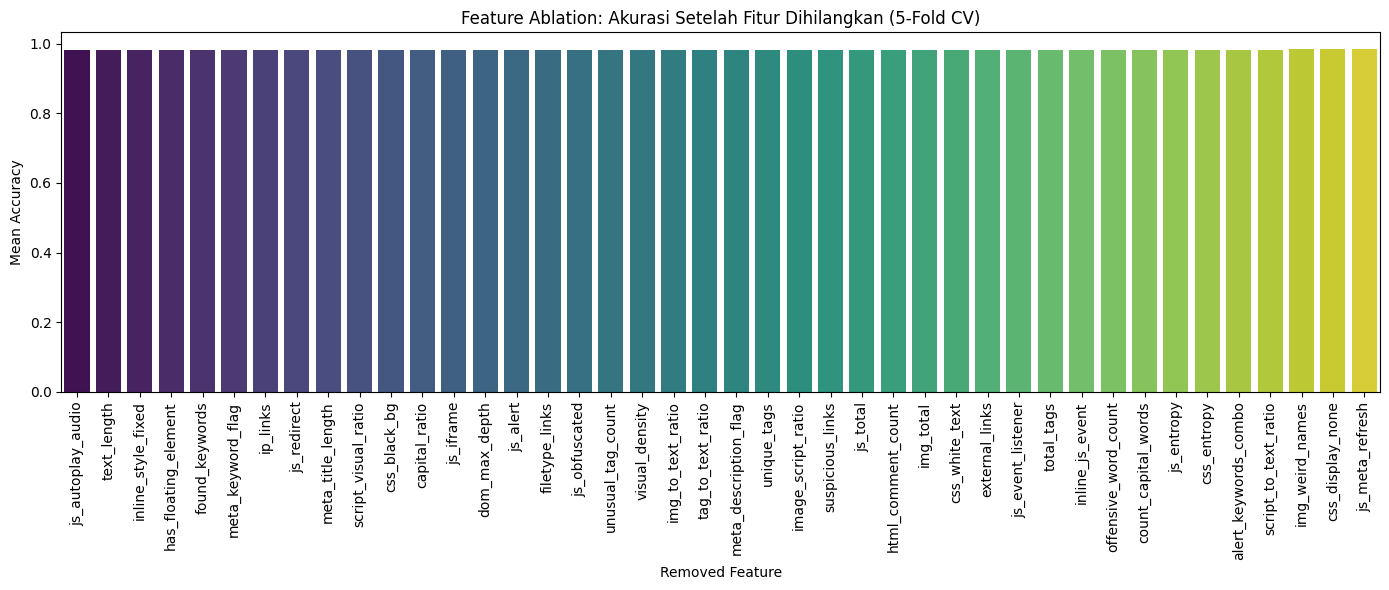


=== [Permutation Feature Importance] ===
                  Feature  Importance Mean  Importance Std
15         found_keywords         0.203726        0.002140
40   alert_keywords_combo         0.020477        0.000828
20         external_links         0.010509        0.000558
19     html_comment_count         0.006718        0.000422
0               img_total         0.005750        0.000468
22             total_tags         0.003871        0.000316
24            text_length         0.003162        0.000281
23            unique_tags         0.002613        0.000350
41     image_script_ratio         0.002153        0.000258
33         filetype_links         0.001928        0.000098
34          dom_max_depth         0.001629        0.000281
1         img_weird_names         0.001597        0.000119
7       js_autoplay_audio         0.001581        0.000217
16      meta_title_length         0.001371        0.000194
10             js_entropy         0.001234        0.000102
14            

<ipython-input-3-c7985fef9c14>:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_df, x="Feature", y="Importance Mean", palette="magma")


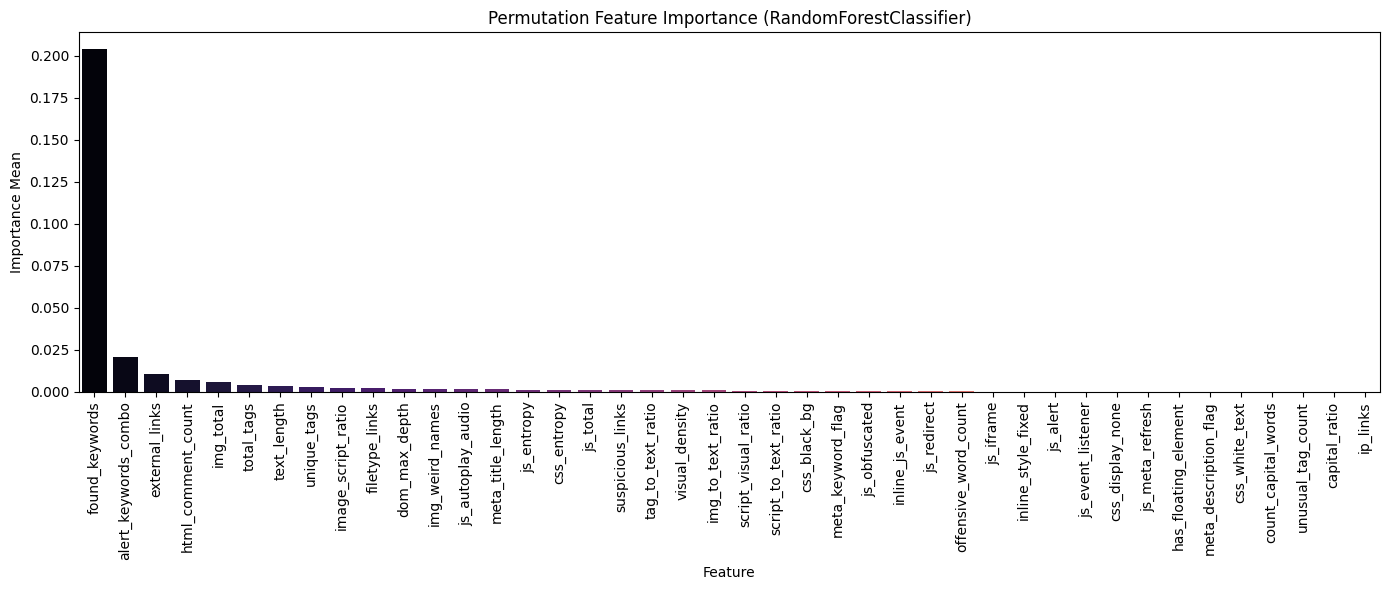

In [ ]:
# === [1] Import Library ===
!pip install scikit-learn --quiet

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance

from google.colab import drive
drive.mount('/content/drive')

# === [2] Load Dataset ===
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/2. Ekstrak Feature Dataset.csv"
df = pd.read_csv(dataset_path)

# === [3] Pilih Fitur ===
important_features = [
    'img_total', 'img_weird_names', 'js_total', 'js_redirect', 'js_iframe',
    'js_meta_refresh', 'js_alert', 'js_autoplay_audio', 'js_event_listener',
    'js_obfuscated', 'js_entropy', 'css_black_bg', 'css_display_none',
    'css_white_text', 'css_entropy', 'found_keywords', 'meta_title_length',
    'meta_keyword_flag', 'meta_description_flag', 'html_comment_count',
    'external_links', 'has_floating_element', 'total_tags', 'unique_tags',
    'text_length', 'count_capital_words', 'offensive_word_count', 'capital_ratio',
    'inline_js_event', 'inline_style_fixed', 'unusual_tag_count',
    'ip_links', 'suspicious_links', 'filetype_links', 'dom_max_depth',
    'tag_to_text_ratio', 'script_to_text_ratio', 'img_to_text_ratio',
    'visual_density', 'script_visual_ratio', 'alert_keywords_combo', 'image_script_ratio'
]

X = df[important_features]
y = df['Label']

#Mengatur Model Random Forest dan Melakukan Klasifikasi, Hasilnya Kemungkinan Deteksi 98%
# === [4] Model Full (Baseline) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("=== [Laporan Klasifikasi] ===")
print(classification_report(y_test, y_pred))

#Mencoba Menggunakan 1 Fitur saja Yakni Keyword Sebagai Acuan, Hasilnya Kemungkinan Deteksi 91%
# === [5] Rule-Based: Threshold found_keywords ===
threshold = 1
rule_based_pred = (df['found_keywords'] >= threshold).astype(int)
rule_based_accuracy = accuracy_score(df['label'], rule_based_pred)
print(f"\n=== [Akurasi Rule-Based: found_keywords >= {threshold}] ===")
print(f"Akurasi: {rule_based_accuracy:.4f}")

#Menampilkan Jumlah Fitur Setiap Label Pada Klasifikasi Normal dan Defaced.
# === [6] Visualisasi Rata-rata Fitur per Label ===
mean_by_label = df.groupby('label')[important_features].mean().reset_index()
melted = pd.melt(mean_by_label, id_vars='label', var_name='Fitur', value_name='Rata-rata')

plt.figure(figsize=(30, 5))
sns.barplot(data=melted, x='Fitur', y='Rata-rata', hue='label')
plt.title("Rata-Rata Nilai Fitur untuk Website Normal vs Defaced")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#Mencoba Untuk Mengkorelasikan Antar Fitur Pada Setiap Label
# === [7] Korelasi antar fitur ===
plt.figure(figsize=(30, 10))
sns.heatmap(
    df[important_features + ['label']].corr(),
    cmap="coolwarm",
    annot=True,        # Tampilkan nilai korelasi
    fmt=".2f",         # Format dua angka di belakang koma
    linewidths=0.5     # (opsional) tambahkan garis antar sel
)
plt.title("Heatmap Korelasi Antar Fitur dan Label")
plt.tight_layout()
plt.show()

# === [8] Cross-Validated Feature Ablation Test ===
print("\n=== [Cross-Validated Feature Ablation Test] ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ablation_results = []

for feature in important_features:
    scores = []
    for train_idx, test_idx in skf.split(X, y):
        X_train_fold = X.iloc[train_idx].drop(columns=[feature])
        X_test_fold = X.iloc[test_idx].drop(columns=[feature])
        y_train_fold = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]

        model_fold = RandomForestClassifier(random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)
        y_pred_fold = model_fold.predict(X_test_fold)
        scores.append(accuracy_score(y_test_fold, y_pred_fold))

    ablation_results.append({
        "Removed Feature": feature,
        "Mean Accuracy": np.mean(scores),
        "Std Dev": np.std(scores)
    })

ablation_df = pd.DataFrame(ablation_results).sort_values(by="Mean Accuracy")
print(ablation_df)

# Visualisasi
plt.figure(figsize=(14, 6))
sns.barplot(data=ablation_df, x="Removed Feature", y="Mean Accuracy", palette="viridis")
plt.xticks(rotation=90)
plt.title("Feature Ablation: Akurasi Setelah Fitur Dihilangkan (5-Fold CV)")
plt.tight_layout()
plt.show()

# === [9] Permutation Feature Importance ===
print("\n=== [Permutation Feature Importance] ===")
full_model = RandomForestClassifier(random_state=42)
full_model.fit(X, y)

perm_result = permutation_importance(full_model, X, y, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance Mean": perm_result.importances_mean,
    "Importance Std": perm_result.importances_std
}).sort_values(by="Importance Mean", ascending=False)

print(perm_df)

# Visualisasi
plt.figure(figsize=(14, 6))
sns.barplot(data=perm_df, x="Feature", y="Importance Mean", palette="magma")
plt.xticks(rotation=90)
plt.title("Permutation Feature Importance (RandomForestClassifier)")
plt.tight_layout()
plt.show()


### **2.2 Menggabungkan Setiap Feature dan Rankingnya Berdasarkan PFA + Ablation Test dan PFI**

<ipython-input-3-6d22fbb116f7>:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_ranked_df.head(10), x="Feature", y="Combined Rank", palette="viridis")


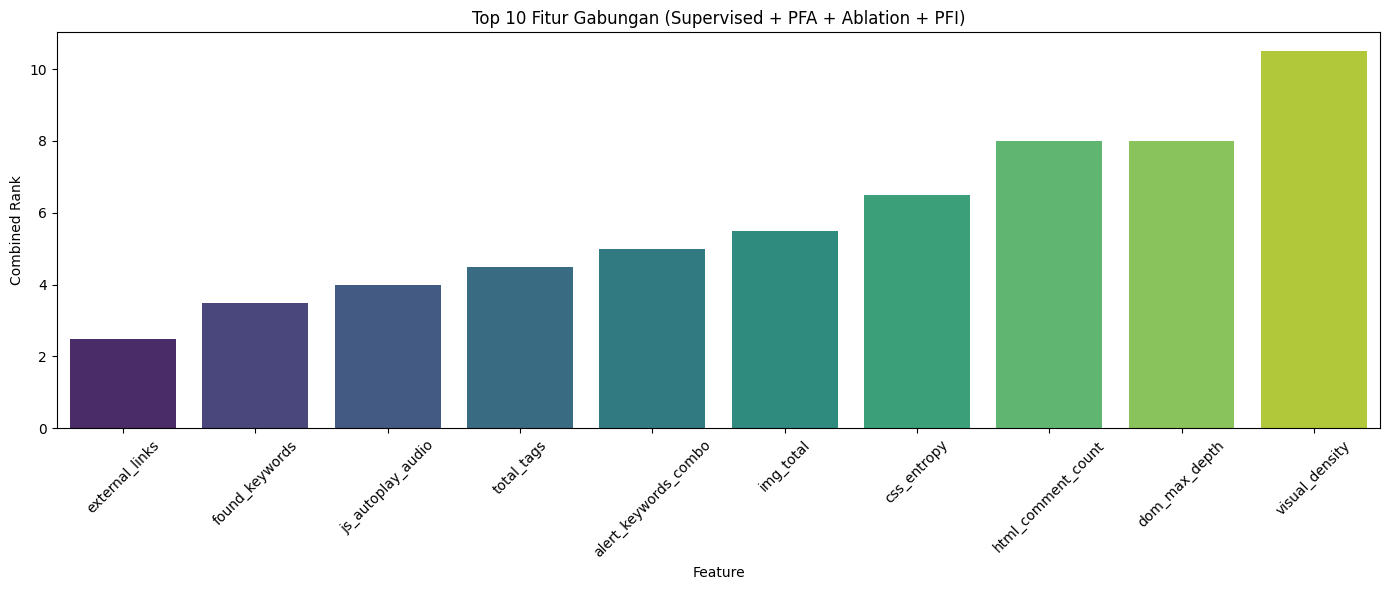

✅ Top 5 Fitur Gabungan:
                Feature  CV Mean Accuracy    CV Std  PFI Mean Importance  \
0        external_links          0.978063  0.002752             0.018381   
1        found_keywords          0.979595  0.001432             0.223655   
2     js_autoplay_audio          0.977579  0.002776             0.009686   
3            total_tags          0.979273  0.003128             0.014453   
4  alert_keywords_combo          0.979837  0.002038             0.026647   

    PFI Std  Ablation Rank  PFI Rank  Combined Rank  
0  0.000679            2.0       3.0            2.5  
1  0.002114            6.0       1.0            3.5  
2  0.000464            1.0       7.0            4.0  
3  0.000805            4.0       5.0            4.5  
4  0.000843            8.0       2.0            5.0  


,Feature,CV Mean Accuracy,CV Std,PFI Mean Importance,PFI Std,Ablation Rank,PFI Rank,Combined Rank
0,external_links,0.978063,0.002752,0.018381,0.000679,2.0,3.0,2.5
1,found_keywords,0.979595,0.001432,0.223655,0.002114,6.0,1.0,3.5
2,js_autoplay_audio,0.977579,0.002776,0.009686,0.000464,1.0,7.0,4.0
3,total_tags,0.979273,0.003128,0.014453,0.000805,4.0,5.0,4.5
4,alert_keywords_combo,0.979837,0.002038,0.026647,0.000843,8.0,2.0,5.0
5,img_total,0.979757,0.001472,0.018292,0.000364,7.0,4.0,5.5
6,css_entropy,0.979111,0.002542,0.005428,0.000363,3.0,10.0,6.5
7,html_comment_count,0.979918,0.002328,0.011928,0.000630,10.0,6.0,8.0
8,dom_max_depth,0.979434,0.001747,0.005371,0.000372,5.0,11.0,8.0
9,visual_density,0.979837,0.002192,0.005194,0.000350,9.0,12.0,10.5


In [ ]:
!pip install -q scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from google.colab import drive, data_table


# === [3] Load Dataset ===
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Data Pre Processing/Dataset After Preprocessing/2. Ekstrak Feature Dataset.csv"
df = pd.read_csv(dataset_path)

# === [4] Definisikan Daftar Fitur ===
important_features = [
    'img_total', 'img_weird_names', 'js_total', 'js_redirect', 'js_iframe',
    'js_meta_refresh', 'js_alert', 'js_autoplay_audio', 'js_event_listener',
    'js_obfuscated', 'js_entropy', 'css_black_bg', 'css_display_none',
    'css_white_text', 'css_entropy', 'found_keywords', 'meta_title_length',
    'meta_keyword_flag', 'meta_description_flag', 'html_comment_count',
    'external_links', 'has_floating_element', 'total_tags', 'unique_tags',
    'text_length', 'count_capital_words', 'offensive_word_count', 'capital_ratio',
    'inline_js_event', 'inline_style_fixed', 'unusual_tag_count',
    'ip_links', 'suspicious_links', 'filetype_links', 'dom_max_depth',
    'tag_to_text_ratio', 'script_to_text_ratio', 'img_to_text_ratio',
    'visual_density', 'script_visual_ratio', 'alert_keywords_combo', 'image_script_ratio'
]

X = df[important_features].copy()
y = df["label"] if "label" in df.columns else df["label"]

# === [5] Normalisasi Fitur ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=important_features)

# === [6] Class: Principal Feature Analysis (PFA) ===
class PFASelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features):
        self.n_features = n_features
        self.top_features_ = None

    def fit(self, X, y=None):
        pca = PCA(n_components=self.n_features)
        pca.fit(X)
        components = np.abs(pca.components_)
        feature_scores = components.max(axis=0)
        self.top_features_ = np.argsort(feature_scores)[-self.n_features:]
        return self

    def transform(self, X):
        return X[:, self.top_features_]

    def get_feature_names(self, feature_list):
        return [feature_list[i] for i in self.top_features_]

# === [7] Supervised Feature Selection (RandomForest) ===
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y)

selector = SelectFromModel(rf_model, threshold="median", prefit=True)
supervised_mask = selector.get_support()
supervised_features = X_scaled_df.columns[supervised_mask]
X_supervised = X_scaled_df[supervised_features].copy()

# === [8] PFA pada fitur hasil supervised ===
pfa = PFASelector(n_features=min(15, len(supervised_features)))
pfa.fit(X_supervised)
pfa_selected_features = pfa.get_feature_names(list(supervised_features))
X_selected = X_supervised[pfa_selected_features]

# === [9] Cross-Validated Ablation Test ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ablation_results = []

for feature in pfa_selected_features:
    acc_scores = []
    for train_idx, test_idx in skf.split(X_selected, y):
        X_train = X_selected.iloc[train_idx].drop(columns=[feature])
        X_test = X_selected.iloc[test_idx].drop(columns=[feature])
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))

    ablation_results.append({
        "Feature": feature,
        "CV Mean Accuracy": np.mean(acc_scores),
        "CV Std": np.std(acc_scores)
    })

ablation_df = pd.DataFrame(ablation_results)

# === [10] Permutation Feature Importance (PFI) ===
model_full = RandomForestClassifier(random_state=42)
model_full.fit(X_selected, y)

perm_result = permutation_importance(model_full, X_selected, y, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    "Feature": pfa_selected_features,
    "PFI Mean Importance": perm_result.importances_mean,
    "PFI Std": perm_result.importances_std
})

# === [11] Gabungkan Rank dan Tampilkan Top-5 Fitur ===
merged_df = pd.merge(ablation_df, perm_df, on="Feature")
merged_df["Ablation Rank"] = merged_df["CV Mean Accuracy"].rank(ascending=True)
merged_df["PFI Rank"] = merged_df["PFI Mean Importance"].rank(ascending=False)
merged_df["Combined Rank"] = (merged_df["Ablation Rank"] + merged_df["PFI Rank"]) / 2
final_ranked_df = merged_df.sort_values(by="Combined Rank").reset_index(drop=True)

# === [12] Visualisasi Top 10 dan Cetak Top 5 ===
plt.figure(figsize=(14, 6))
sns.barplot(data=final_ranked_df.head(10), x="Feature", y="Combined Rank", palette="viridis")
plt.title("Top 10 Fitur Gabungan (Supervised + PFA + Ablation + PFI)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✅ Top 5 Fitur Gabungan:")
print(final_ranked_df.head(5))

# === [11] Tampilkan Tabel Interaktif ===
data_table.DataTable(final_ranked_df)